# Machinaal Leren - Sprint 2: Text Data

## Task:
What insights can we gain from the text data (title, description and reviews) ?

Possible tasks:
* Detect duplicate listings
* Extract keywords from reviews / descriptions
* Automatically make a list of positive and negative points for a listing based on the reviews
* Recognize listings from the same owner
* Detect anomalies (listings/ reviews that are very different from other listings/ reviews)
* Detect reviews that are very similar
* Perform sentiment analysis on a review
* ...

## Work table


|Task|Peter Bonnarens|Philip Kukoba|Lennert Franssens|
|------|------|------|------|
|1. Loading and cleaning dataset  | X | X | X |
|2. Detect duplicate listings  | X |  |   |
|3. Keyword extraction  |   | X |   |
|4. Positive and negative points from review  |   |   | X |
|5. Topic modeling  |   |   | X |
|6. Sentiment analysis  |   |   | X |
|7. Similar reviews  |   |   | X |

# **1 - LOADING THE DATASET**

## Import packages and read datasets

Here we import the needed packages for this notebook, download some utilities and read the listings and reviews datasets.

If you want to run this notebook, please run the following command in your environment:
```bash
python -m pip install langdetect pyLDAvis textblob tensorflow tensorflow_hub pandas_profiling wordcloud
```

In [5]:
%matplotlib inline

# run this in your environment: python -m pip install langdetect pyLDAvis textblob tensorflow tensorflow_hub pandas_profiling wordcloud

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import seaborn as sns
import warnings
import tensorflow as tf
import tensorflow_hub as hub
import os
import os.path
import re
import heapq
import gensim
import pickle
import nltk
import unicodedata
import pandas_profiling as pp
import gensim.parsing.preprocessing as gsp
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from absl import logging
from matplotlib import rcParams
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.models import Word2Vec
from TextRank.keyword_extractor import KeywordExtractor
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim import utils
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim.similarities import Similarity
from wordcloud import WordCloud

# if u want to run this yourself: 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
# delete warnings from output
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# figure size in inches
plt.rcParams['figure.figsize'] = 15, 12

# loading the datasets into pandas dataframes
reviews = pd.read_csv("data/reviews.csv")
listings = pd.read_csv("data/listings.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lennertfranssens/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lennertfranssens/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lennertfranssens/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/lennertfranssens/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /home/lennertfranssens/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [6]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,187870,540088,2011-09-17,1003634,Dominick,"This is a very lovely room. The room, bathroom..."
1,187870,581572,2011-09-29,178012,Nancy,Tamara's place in Ghent was really nice and cl...
2,187870,715167,2011-11-13,1391583,Charlotte,We spend one night at Tamara's and it was perf...
3,187870,834756,2012-01-03,1513484,Ger Y Flo,"Pasamos unos dias increibles en Gante, la habi..."
4,187870,855004,2012-01-10,1503813,Max,My girlfriend and I had the most wonderful tim...


In [7]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Unnamed: 74
0,187870,https://www.airbnb.com/rooms/187870,20210716195504,2021-07-16,Luxury studio 'Spiegelhof' in the centre of Ghent,The top floor of our house in the center of Gh...,We live in a quiet and pleasant neighborhood w...,https://a0.muscache.com/pictures/26c46224-795c...,904277,https://www.airbnb.com/users/show/904277,...,4.58,4.85,NaN,t,1,0,1,0,3.61,NaN
1,203806,https://www.airbnb.com/rooms/203806,20210716195504,2021-07-16,Flat close to Sint-Pieters Station!,This well-located and comfortable one-bedroom ...,The house is located in a dead-end street - so...,https://a0.muscache.com/pictures/fe477b7f-93ac...,999847,https://www.airbnb.com/users/show/999847,...,4.49,4.54,NaN,f,2,2,0,0,2.84,NaN
2,204245,https://www.airbnb.com/rooms/204245,20210716195504,2021-07-16,Modern studio's in Ghent centre,<b>The space</b><br />We offer luxury studio's...,NaN,https://a0.muscache.com/pictures/1766072/02965...,1003009,https://www.airbnb.com/users/show/1003009,...,4.97,4.63,NaN,f,2,2,0,0,0.29,NaN
3,216715,https://www.airbnb.com/rooms/216715,20210716195504,2021-07-16,converted loft,Please read full desription for how to get the...,It's close to all that you will want or need v...,https://a0.muscache.com/pictures/1927009/20760...,911466,https://www.airbnb.com/users/show/911466,...,4.89,4.76,NaN,t,1,1,0,0,4.31,NaN
4,252269,https://www.airbnb.com/rooms/252269,20210716195504,2021-07-16,Large & bright town House - Center Ghent - max 8p,"bright, spacious, authentic & beautifully rest...","our neighbourhood is quiet, but nicely vibrati...",https://a0.muscache.com/pictures/69675b54-3e78...,1195314,https://www.airbnb.com/users/show/1195314,...,4.98,4.72,NaN,f,1,1,0,0,2.23,NaN


Find lines to shift and add them to a mask - we've found that some lines are shifted 1 to the right beginning on the host_id column (that now contains garbage data)

In [8]:
shifted_lines = listings[pd.to_numeric(listings["host_verifications"], errors='coerce').notnull()].id
mask = listings['id'].isin(shifted_lines)

# shift lines 1 to the left
listings.loc[mask, 'host_since':'reviews_per_month'] = listings.loc[mask, 'host_since':'reviews_per_month'].shift(-1, axis=1)

In [9]:
listings.drop(['host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_listings_count','host_total_listings_count',
            'host_has_profile_pic','host_identity_verified','latitude','longitude','accommodates','bathrooms','bedrooms','beds','price','minimum_nights',
            'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
            'maximum_nights_avg_ntm','calendar_updated','has_availability','availability_30','availability_60','availability_90','availability_365',
            'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review','license','instant_bookable','calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
            'reviews_per_month'], axis=1)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,amenities,calendar_last_scraped,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,Unnamed: 74
0,187870,https://www.airbnb.com/rooms/187870,20210716195504,2021-07-16,Luxury studio 'Spiegelhof' in the centre of Ghent,The top floor of our house in the center of Gh...,We live in a quiet and pleasant neighborhood w...,https://a0.muscache.com/pictures/26c46224-795c...,904277,https://www.airbnb.com/users/show/904277,...,"[""Microwave"", ""Keypad"", ""Extra pillows and bla...",2021-07-16,4.85,4.90,4.95,4.90,4.87,4.58,4.85,NaN
1,203806,https://www.airbnb.com/rooms/203806,20210716195504,2021-07-16,Flat close to Sint-Pieters Station!,This well-located and comfortable one-bedroom ...,The house is located in a dead-end street - so...,https://a0.muscache.com/pictures/fe477b7f-93ac...,999847,https://www.airbnb.com/users/show/999847,...,"[""Dishwasher"", ""Ethernet connection"", ""Microwa...",2021-07-16,4.59,4.72,4.73,4.80,4.79,4.49,4.54,NaN
2,204245,https://www.airbnb.com/rooms/204245,20210716195504,2021-07-16,Modern studio's in Ghent centre,<b>The space</b><br />We offer luxury studio's...,NaN,https://a0.muscache.com/pictures/1766072/02965...,1003009,https://www.airbnb.com/users/show/1003009,...,"[""Shampoo"", ""Wifi"", ""TV"", ""Heating"", ""Dedicate...",2021-07-16,4.79,4.73,4.93,4.83,4.70,4.97,4.63,NaN
3,216715,https://www.airbnb.com/rooms/216715,20210716195504,2021-07-16,converted loft,Please read full desription for how to get the...,It's close to all that you will want or need v...,https://a0.muscache.com/pictures/1927009/20760...,911466,https://www.airbnb.com/users/show/911466,...,"[""Long term stays allowed"", ""Microwave"", ""Cook...",2021-07-16,4.75,4.81,4.90,4.89,4.85,4.89,4.76,NaN
4,252269,https://www.airbnb.com/rooms/252269,20210716195504,2021-07-16,Large & bright town House - Center Ghent - max 8p,"bright, spacious, authentic & beautifully rest...","our neighbourhood is quiet, but nicely vibrati...",https://a0.muscache.com/pictures/69675b54-3e78...,1195314,https://www.airbnb.com/users/show/1195314,...,"[""Hot water kettle"", ""Dishwasher"", ""Microwave""...",2021-07-16,4.89,4.92,4.93,4.92,4.97,4.98,4.72,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,51022259,https://www.airbnb.com/rooms/51022259,20210716195504,2021-07-16,Full apartment near Sint Pieters Station,This is a 2 bedroom apartment. Guests will en...,Apartment is located in neighborhood of Sint P...,the main station in Ghent. The street is very...,https://a0.muscache.com/pictures/47c0402d-8d28...,97573561,...,"[""Microwave"", ""Fire extinguisher"", ""Dishes and...",2021-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
919,51036302,https://www.airbnb.com/rooms/51036302,20210716195504,2021-07-16,Guesthouse Flora,Geniet van de moderne en ouderwetse charme van...,De Flora is het meest noordelijke gedeelte van...,https://a0.muscache.com/pictures/186f59af-f089...,171955140,https://www.airbnb.com/users/show/171955140,...,"[""Hot water kettle"", ""Microwave"", ""Extra pillo...",2021-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
920,51053223,https://www.airbnb.com/rooms/51053223,20210716195504,2021-07-16,Large modern house 10min from downtown Ghent/Gent,Just 10 minutes from historic downtown Ghent. ...,NaN,https://a0.muscache.com/pictures/7de8d4c4-0155...,2650664,https://www.airbnb.com/users/show/2650664,...,"[""Baby safety gates"", ""Dishwasher"", ""Backyard""...",2021-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
921,51056846,https://www.airbnb.com/rooms/51056846,20210716195504,2021-07-16,"Comfort, quiet en green in ancient part of center",NaN,NaN,https://a0.muscache.com/pictures/a7faff71-0c08...,45920980,https://www.airbnb.com/users/show/45920980,...,"[""Air conditioning"", ""Paid parking off premise...",2021-07-16,NaN,NaN,NaN,NaN,Na

Drop all rows without comments. And remove html syntax and clean other symbols out of the comment corpus. 

In [10]:
reviews = reviews.dropna()
reviews_points = reviews.copy()
reviews_original = reviews.copy()

# Remove <b> tags and text in between it
reviews['comments'] = reviews['comments'].str.replace(r'<b>.*?<\/b>', '', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'<b>.*?<\/b>', '', regex=True)

# Remove all HTML tags
reviews['comments'] = reviews['comments'].str.replace(r'<[^<>]*>', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'<[^<>]*>', ' ', regex=True)

# Remove all special characters (non-word)
reviews['comments'] = reviews['comments'].str.replace(r'\W', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'[^\w\s\'\.\/]', '.', regex=True)

# Remove all single characters (like a floating 'b' after removing the HTML tags around it)
reviews['comments'] = reviews['comments'].str.replace(r'\s+[a-zA-Z]\s+', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\s+[a-zA-Z]\s+', ' ', regex=True)

# Remove single characters at the start
reviews['comments'] = reviews['comments'].str.replace(r'\^[a-zA-Z]\s+', ' ', regex=True)
#reviews_points['comments'] = reviews_points['comments'].str.replace(r'\^[a-zA-Z]\s+', ' ', regex=True)

# Substitute multiple spaces with a single space
reviews['comments'] = reviews['comments'].str.replace(r'\s+', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\s+', ' ', regex=True)

# Replace multiple dots with one dot
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\.+', '.', regex=True)

# Remove space(s) before dot
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\s+\.', '.', regex=True)

# Convert to lowercase
reviews['comments'] = reviews['comments'].str.lower()
reviews_points['comments'] = reviews_points['comments'].str.lower()

In [11]:
# Remove <b> tags and text in between it
listings['description'] = listings['description'].str.replace(r'<b>.*?<\/b>', '', regex=True)

# Remove all HTML tags
listings['description'] = listings['description'].str.replace(r'<[^<>]*>', ' ', regex=True)

# Remove NaN values
listings = listings[listings['description'].notna()]

# To lowercase
listings["description"] = listings["description"].str.lower()

## **2 - DETECT DUPLICATE LISTINGS**

## Naive method
At first, detecting duplicate listings seems easy. We could try using a naive approach where we check if listings have the same description.

In [12]:
duplicates = listings[listings.duplicated(['description']) == True]

Let's take a look at some of these 'duplicates'

In [13]:
display(duplicates[duplicates.id.isin([17415990,17416223,17416437,17416518])])

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Unnamed: 74
241,17415990,https://www.airbnb.com/rooms/17415990,20210716195504,2021-07-16,Edville studio Duplex (2p-4p),studio edville gent biedt verschillende studio...,Studio Edville Gent is gelegen aan het water i...,https://a0.muscache.com/pictures/c556f91d-8b55...,414263,https://www.airbnb.com/users/show/414263,...,4.67,3.67,NaN,t,8,7,0,0.0,0.08,NaN
242,17416223,https://www.airbnb.com/rooms/17416223,20210716195504,2021-07-16,Edville studio Duplex A304 (2p-4p),studio edville gent biedt verschillende studio...,Studio Edville Gent is gelegen aan het water i...,https://a0.muscache.com/pictures/56f70957-aa6d...,414263,https://www.airbnb.com/users/show/414263,...,4.50,3.50,NaN,t,8,7,0,0.0,0.05,NaN
244,17416437,https://www.airbnb.com/rooms/17416437,20210716195504,2021-07-16,Edville Studio,studio edville gent biedt verschillende studio...,Studio Edville Gent is gelegen aan het water i...,https://a0.muscache.com/pictures/8719d90e-105b...,414263,https://www.airbnb.com/users/show/414263,...,4.78,4.22,NaN,t,8,7,0,0.0,0.24,NaN
245,17416518,https://www.airbnb.com/rooms/17416518,20210716195504,2021-07-16,Edville Studio,studio edville gent biedt verschillende studio...,Studio Edville Gent is gelegen aan het water i...,https://a0.muscache.com/pictures/352bf500-612e...,414263,https://www.airbnb.com/users/show/414263,...,4.58,4.25,NaN,t,8,7,0,0.0,0.28,NaN


We can see that these 4 listings share the same description. However, if we read the description we notice that these listings are spread over 2 different buildings. This indicates that these listings are not all the same listing but rather 2 separate listings that are both duplicated. 
If we take a look at the latitude/longitude we see that these listings share the same location, suggesting that these listings are in 1 building while the description says that there are 2 separate buildings. If we look at the price, we see that the prices of every listing here is different.

In conclusion: we have a hard time telling if these listings are duplicates or not. Let us first look at another example.

In [14]:
display(duplicates[duplicates.id.isin([42166580,42166739,42353100])])

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Unnamed: 74
674,42166580,https://www.airbnb.com/rooms/42166580,20210716195504,2021-07-16,Welcome in Ghent: private newly renovated house,our recently renovated house on 5 min from the...,"There is bus 3 around the corner, in 2 min you...",https://a0.muscache.com/pictures/9f1c93b3-1142...,36152908,https://www.airbnb.com/users/show/36152908,...,NaN,NaN,NaN,f,4,4,0,0.0,NaN,NaN
675,42166739,https://www.airbnb.com/rooms/42166739,20210716195504,2021-07-16,Comfortable private modern house in the city,our recently renovated house on 5 min from the...,"There is bus 3 around the corner, in 2 min you...",https://a0.muscache.com/pictures/9ccb1f32-9833...,36152908,https://www.airbnb.com/users/show/36152908,...,NaN,NaN,NaN,f,4,4,0,0.0,NaN,NaN
678,42353100,https://www.airbnb.com/rooms/42353100,20210716195504,2021-07-16,Cozy and private familyhouse in the city,our recently renovated house on 5 min from the...,"There is bus 3 around the corner, in 2 min you...",https://a0.muscache.com/pictures/ab6042c6-fa09...,36152908,https://www.airbnb.com/users/show/36152908,...,NaN,NaN,NaN,f,4,4,0,0.0,NaN,NaN


These 3 listings also share the same description. If we take a quick glance at the included picture_url, they have different links but all show the same photo. The names of the listings are different, but describe the same kind of listing. Maybe these listings really are duplicates?
If we look at the latitude/longitude, we notice that they are all slightly different... The prices of these listings are also different: €90 for the first and €120 for the other 2.

Again we have to conclude that it is hard to say that these listings are duplicates by only looking at the description, latitude/longitude, price, ...

## Trying to detect similar listings based on the descriptions

Let us simplify this problem and say that listings with the same description are very likely to be duplicates. This raises another problem: what if there are listings that have almost the same description but with a few different words? Simply checking if the descriptions are the same will return that these listings are not duplicates. In order to tackle this problem we will be using some modules from `Gensim`.

First, we only want to keep the 'id' and 'description' of our listings for this part.

In [15]:
listings = listings[["id", "description"]]

Next, we noticed that our dataset contains listings in multiple languages. Before we continue we should detect what languages the descriptions are written in, and how many listings we have in each language. To do this, we will be using the `langdetect` library which supports 55 languages out of the box (link: https://pypi.org/project/langdetect/).

In [16]:
description_languages = []
for description in listings["description"].values:
    try:
        description_languages.append(detect(description))
    except: #the detect function rarely fails, but when it does it can crash the for loop
        description_languages.append("unknown")

In [17]:
listings["language"] = description_languages
language_count_listings = listings.groupby(['language']).count()
print(language_count_listings)

           id  description
language                  
af          2            2
en        705          705
fr          2            2
nl        189          189


Here we see that most of the descriptions are written in english (~ 78%) or dutch (~ 21%). We will only be using the english descriptions since they represent the largest part of our dataset and most nlp models were intended to be used on the english language.

In [18]:
listings_english = listings[listings["language"] == "en"]
print(listings_english.shape)

(705, 3)


Now that we have our listings that we want, we can start preprocessing our data. We transform our pandas dataframe into a list of documents and apply some filters by using the `preprocessing`module from `Gensim`. These steps are inspired on this tutorial: https://towardsdatascience.com/a-laymans-guide-to-fuzzy-document-deduplication-a3b3cf9a05a7 .

In [19]:
filters = [
           gsp.strip_tags,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords,
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

documents = listings_english["description"].to_list()
texts = [clean_text(doc) for doc in documents]

Next, we will use the word-level structures to train a Gensim n-graph phraser. A normal bigram generator would produce a bigram for each word pair. We will be using the `Phraser` module from Gensim, which is pretrained to select collocations or words that would commonly be found together. This will save program runtime by not storing a feature for every possible permutation of words. The `min_count` argument specifies how many times the phrase must be found in the corpus to be kept.

After training the Phraser, we use it to convert documents to collections of words/bigrams.

In [20]:
bigram = Phrases(texts, min_count=1)
bigram_phraser = Phraser(bigram)

texts_bigrams = [[text for text in bigram_phraser[ simple_preprocess(doc, deacc=True)]] for doc in documents]

To be able to use the Gensim module, we need to create a corpus and dictionary with some package-specific structure.

In [21]:
dictionary = corpora.Dictionary(texts_bigrams)
corpus = [dictionary.doc2bow(docString) for docString in texts_bigrams]

The dictionary maps each specific term to a unique ID. The corpus uses the dictionary we created to convert our original text documents to a numeric representation. Next, we create a similarity index to calculate the cosine similarity for our collection of document-term vectors. 

In [22]:
index = Similarity(corpus=corpus,
                   num_features=len(dictionary),
                   output_prefix='on_disk_output')

Now we can create a dictionary `similar_docs` which tracks each document and the similarity scores between it and all the other documents in the corpus.

In [23]:
doc_id = 0
similar_docs = {}
for similarities in index:
    similar_docs[doc_id] = list(enumerate(similarities))
    doc_id += 1

At last, we set a certain threshold that indicates how similar documents need to be before we consider them duplicates. This is a value that needs to be chosen (we set it at 0.9). Then we can loop over the `similar_docs` dictionary and store all the documents that pass the threshold in a new dictionary `duplicates`.

In [24]:
sim_threshold = 0.9
duplicates = {}
for doc_id, sim_doc_tuples in similar_docs.items():
    for sim_doc_tuple in sim_doc_tuples:
        sim_doc_id = sim_doc_tuple[0]
        sim_score = sim_doc_tuple[1]
        
        if sim_score >= sim_threshold and doc_id != sim_doc_id:
            if doc_id not in duplicates:
                duplicates[doc_id] = []
            duplicates[doc_id].append(sim_doc_id)

This dictionary now contains all the documents that our model considers duplicates. Let us take a look at the first element in the dictionary.

In [25]:
print(next(iter(duplicates.items())))

(9, [10, 15, 346])


We see that the document with id 9 has 3 other documents that are considered duplicates: 10, 15 and 347. If we print out these documents we see that they are almost completely identical, but a few words are different or certain sentences were left out. This means that if we had just checked if the descriptions were equal, we would not have found these duplicates.

In [26]:
print(documents[9])
print("-----")
print(documents[10])
print("-----")
print(documents[15])
print("-----")
print(documents[347])
print("-----")

this is a new self-catered studio situated in a hip upcoming neighbourhood of the center of ghent.  ideal for 1 person or couple.  erasmus or phd student.   with private kitchen and bathroom (shower, toilet, lavabo).  fully furnished and equipped kitchen.   this is a new self-catered studio in the center of ghent. windows in the front and the back.  fully equipped kitchen with fridge, combi-oven, ceramic hob and coffee machine.  the bathroom is equipped with lavabo, toilet and big shower 85 x 120.  the big desk makes it possible to do some office work. the studio remains always spacious because of the smart bed solution.  ideal for a touristic, educational or business stay for short or lang term.  please feel free to contact us if you have any questions   the studio is on the first floor.  there is a bike storage room on the ground floor. there ar 6 studio's in the building. two on 
-----
this is a new self-catered studio situated in a hip upcoming neighbourhood of the center of ghent.

## **3 - Keyword extraction**
### Keyword extraction from reviews using TF-IDF

To extract keywords from reviews, we first opt for TF-IDF. The term comes down to how many times a certain word occurs in a review (document), divided by the the number of reviews (documents) it occurs in.

Before running TF-IDF, we first have to detect the language of each review (since for example stop words are unique for a language). Be warned, the code below takes a while to compute.

In [27]:
all_languages = []
for review in reviews["comments"].values:
    try:
        all_languages.append(detect(review))
    except: #the detect func rarely fails, but when it does it can crash the for loop
        all_languages.append("unknown")
# all_languages

We add a column to our dataframe and look at the results.

In [28]:
reviews["language"] = all_languages
reviews["language"].value_counts().head()

en    27640
nl    11769
fr     6162
es     1990
de     1185
Name: language, dtype: int64

Most reviews are in English (en). We will keep only the English reviews since most libraries are optimal for English (eg stop words for tf-idf).

In [29]:
english_reviews = reviews[reviews["language"] == 'en']
english_reviews_copy = english_reviews.copy() #todo remove
english_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,187870,540088,2011-09-17,1003634,Dominick,this is very lovely room the room bathroom eve...,en
1,187870,581572,2011-09-29,178012,Nancy,tamara place in ghent was really nice and clea...,en
2,187870,715167,2011-11-13,1391583,Charlotte,we spend one night at tamara and it was perfec...,en
4,187870,855004,2012-01-10,1503813,Max,my girlfriend and had the most wonderful time ...,en
5,187870,897168,2012-02-01,581462,Eva,we had lovely stay with tamara and anna in ghe...,en
...,...,...,...,...,...,...,...
50910,50207003,398977730778256896,2021-07-04,5275569,Mathias,great appartement in nice part of the city lov...,en
50911,50297619,401873565247888378,2021-07-08,408597262,Nacho,amazing and spacious flat good location and ve...,en
50915,50431051,394711577334590933,2021-06-28,347114686,Mandy,nathalie loft is incredible very open space wi...,en
50916,50475480,398328411988280868,2021-07-03,399018965,Kevin,the place is neat and the system to go there i...,en


We set-up the CountVectorizer and TfidTransformer properly for TF-IDF.

In [30]:
#todo optimise?
count_vect = CountVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    min_df=2,   
    max_df=0.5
)

X_train_counts = count_vect.fit_transform(english_reviews["comments"])

tf_transformer = TfidfTransformer()
X_train_tf = tf_transformer.fit_transform(X_train_counts) # is a matrix

X_train_tf   # matrix of #entries x #words(features)

<27640x65139 sparse matrix of type '<class 'numpy.float64'>'
	with 964751 stored elements in Compressed Sparse Row format>

We will add a column to our DataFrame with the top 5 keywords for this comment based on TF-IDF.

In [31]:
feature_names=count_vect.get_feature_names()

top_5_keywords_column = []
i = 0 
for review in english_reviews["comments"]: 

    # numpy array troubles to find the indices and tf-idf values, using regex
    np_arr = np.array(X_train_tf[i])
    np_arr_str = str(np_arr)
    arr = np_arr_str.split("\n")
    feature_indices = []
    feature_values = []
    j = 0
    for el in arr:
        try:
            regex_result = re.search(r"  \(\d, (\d*)\)\t(\d\.\d*)", el)
            feature_indices.append(regex_result.group(1))
            feature_values.append(regex_result.group(2))
        except:
            break
        j += 1
     
    top_5_tf_idf_indices = heapq.nlargest(5, range(len(feature_values)), feature_values.__getitem__)
    
    top_5_keywords = []
    for ind in top_5_tf_idf_indices:   
        true_index = int(feature_indices[ind])
        top_5_keywords.append(feature_names[true_index])
    
    top_5_keywords_column.append(top_5_keywords)   
    i += 1
    
english_reviews["top_5_keywords"] = top_5_keywords_column

english_reviews[["comments","top_5_keywords"]]

,comments,top_5_keywords
0,this is very lovely room the room bathroom eve...,"[touch helpful, hosts touch, helpful absolutel..."
1,tamara place in ghent was really nice and clea...,"[tamara, tamara briefly, pitcher, met tamara, ..."
2,we spend one night at tamara and it was perfec...,"[tamara perfect, tamara, infos city, host gent..."
4,my girlfriend and had the most wonderful time ...,"[tamara, perfect tamara, location spent, time ..."
5,we had lovely stay with tamara and anna in ghe...,"[tamara anna, tamara, anna, city live, ghent w..."
...,...,...
50910,great appartement in nice part of the city lov...,"[loved interior, appartement nice, great appar..."
50911,amazing and spacious flat good location and ve...,"[location helpful, amazing spacious, spacious ..."
50915,nathalie loft is incredible very open space wi...,"[rain showers, sharing space, thanks sharing, ..."
50916,the place is neat and the system to go there i...,"[ll recommend, place neat, recommend sure, eff..."


Looking at the output above, the results are pretty good. Consider the rows 1 to 5 where 'tamara' is an important keyword. This is logical since the host name is highly unique for these reviews of a host.

### Keyword extraction using word embeddings
For the next part we will try a more advanced technique, word embeddings. A word is mapped to a point in a high dimensional space, where words with similar meanings are mapped to nearby points. This opens the door for discovering more complex relationships. We will use the word embedding technique of Word2Vec. 

Word2vec is a two-layer neural network which vectorises words. While it is not a deep neural network, it does turn text into a numerical form (set of vectors) that deep neural networks can easily understand. Word2vec trains words against other words that neighbor them in the input corpus. We will use the skip-gram approach, where words are predicted in a certain range before and after the current word in the same sentence.

When the feature vector that is assigned to a word cannot be used to predict that word's context, the components of this vector are adjusted. Each word's context in the corpus is the te

For this we use the Word2Vec implementation by gensim.

Before training a word2vec model we need to adjust the input data to a 'list of lists' model.

In [32]:
listoflists = [row.split(" ") for row in english_reviews["comments"]]
listoflists[:2] #print examples

[['this',
  'is',
  'very',
  'lovely',
  'room',
  'the',
  'room',
  'bathroom',
  'everything',
  'was',
  'very',
  'clean',
  'the',
  'location',
  'very',
  'good',
  'walking',
  'distance',
  'from',
  'most',
  'touristic',
  'sights',
  'the',
  'guests',
  'anneke',
  'en',
  'tamara',
  'were',
  'great',
  'hosts',
  'always',
  'in',
  'touch',
  'and',
  'very',
  'helpful',
  'absolutely',
  'recommend',
  ''],
 ['tamara',
  'place',
  'in',
  'ghent',
  'was',
  'really',
  'nice',
  'and',
  'clean',
  'and',
  'had',
  'everything',
  'we',
  'needed',
  'for',
  'short',
  'stay',
  'comfortable',
  'bed',
  'towels',
  'etc',
  'even',
  'though',
  'we',
  'only',
  'met',
  'tamara',
  'briefly',
  'she',
  'was',
  'super',
  'friendly',
  'and',
  'helpful',
  'giving',
  'us',
  'maps',
  'and',
  'city',
  'guides',
  'and',
  'even',
  'leaving',
  'us',
  'fresh',
  'pitcher',
  'of',
  'water',
  'and',
  'chocolate',
  'almonds',
  'on',
  'our',
  'arri

We train a word2vec model. sg=1 means we use skip gram.

In [33]:
w2v_model = Word2Vec(listoflists, workers=3, window =3, sg = 1)
w2v_model.save("w2v_model")

We test our model:

In [34]:
w2v_model.wv.most_similar(positive=["loft"])

[('apartment', 0.7849008440971375),
 ('flat', 0.7376296520233154),
 ('townhouse', 0.7057455778121948),
 ('studio', 0.6956659555435181),
 ('penthouse', 0.6929054856300354),
 ('duplex', 0.6791545152664185),
 ('appartament', 0.677592396736145),
 ('bright', 0.6737447381019592),
 ('residence', 0.6729270219802856),
 ('unit', 0.66672682762146)]

The model gives a logical output. Similar words to loft are other types of housing.

### Keyword extraction using TextRank

Since Word2vec seems to be working well, we would like to use its power for keyword extraction. Herefor we choose a TextRank implementation which relies on a trained word2vec model. TextRank is a graph-based ranking model for text processing, commonly used for keyword extraction and text summarization. It sets up a graph structure with words as nodes and edges for related words. Each word is connected to other words that are close to it in the text.

The more connected a word is, the higher its weight. This is done with the TextRank algorithm. Each node is given a weight of 1. Then the algorithm iterates the list of nodes and collects the influence of each of its inbound connections, this is usually just the value of the connected vertex and then summed up to determine the new score for the node. Then the scores are normalised so the highest score becomes 1 and the rest is scaled from 0 to 1. This is repeated until the values stop changing. 



Source: https://github.com/naiveHobo/TextRank

In [35]:
extractor = KeywordExtractor(word2vec="w2v_model")

Loading word2vec embedding...
Succesfully loaded word2vec embeddings!


In [36]:
keywords_word2vec = []    
for review in english_reviews["comments"]: 
    keywords = extractor.extract(review, ratio=1, split=True)
    keywords_word2vec.append(keywords)
    
english_reviews["keywords_word2vec"] = keywords_word2vec
english_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,top_5_keywords,keywords_word2vec
0,187870,540088,2011-09-17,1003634,Dominick,this is very lovely room the room bathroom eve...,en,"[touch helpful, hosts touch, helpful absolutel...","[bathroom everything, walking distance, room]"
1,187870,581572,2011-09-29,178012,Nancy,tamara place in ghent was really nice and clea...,en,"[tamara, tamara briefly, pitcher, met tamara, ...","[tamara place, briefly]"
2,187870,715167,2011-11-13,1391583,Charlotte,we spend one night at tamara and it was perfec...,en,"[tamara perfect, tamara, infos city, host gent...","[center, host, perfect, city]"
4,187870,855004,2012-01-10,1503813,Max,my girlfriend and had the most wonderful time ...,en,"[tamara, perfect tamara, location spent, time ...",[tamara home]
5,187870,897168,2012-02-01,581462,Eva,we had lovely stay with tamara and anna in ghe...,en,"[tamara anna, tamara, anna, city live, ghent w...",[]
...,...,...,...,...,...,...,...,...,...
50910,50207003,398977730778256896,2021-07-04,5275569,Mathias,great appartement in nice part of the city lov...,en,"[loved interior, appartement nice, great appar...",[]
50911,50297619,401873565247888378,2021-07-08,408597262,Nacho,amazing and spacious flat good location and ve...,en,"[location helpful, amazing spacious, spacious ...",[host]
50915,50431051,394711577334590933,2021-06-28,347114686,Mandy,nathalie loft is incredible very open space wi...,en,"[rain showers, sharing space, thanks sharing, ...","[nathalie, city center, energy thanks, space]"
50916,50475480,398328411988280868,2021-07-03,399018965,Kevin,the place is neat and the system to go there i...,en,"[ll recommend, place neat, recommend sure, eff...",[]


The results are far from good. At first one might think that this is because of the ratio parameter in the extract method, but after trying out different ratio's, the method still results in 0 keywords for most reviews. This specific implementation of TextRank might be simply non-optimised, as it only considers one specific review at a time, unlike TF-IDF which considers all reviews.

Even when it does extract keywords, note that the results still can differ from the TF-IDF approach. 

# **4 - LISTING POSITIVE AND NEGATIVE POINTS FROM REVIEWS**

References:
* https://textblob.readthedocs.io/en/dev/quickstart.html

We would like to extract positive positive and negative points (sentences) from a review. We will first go over the reviews and only keep the English ones. Then we apply a library that does natural language processing (NLP) tasks. As a final step, we will write out the most positive and negative points (phrases) per review.

## Keep English reviews

This is the same code as in **3 - Keyword extraction** but applied on the different cleaned reviews dataset. After we did that, we already make a copy of the *English only* dataset for further tasks in this notebook.

In [37]:
all_languages = []
for review in reviews_points["comments"].values:
    try:
        all_languages.append(detect(review))
    except: #the detect func rarely fails, but when it does it can crash the for loop
        all_languages.append("unknown")

reviews_points["language"] = all_languages
reviews_points = reviews_points[reviews_points["language"] == 'en']
reviews_points = reviews_points.drop(['language'], axis=1)

reviews_similar = reviews_points.copy()

## Apply TextBlob NLP library

We now apply the TextBlob library onto the comments column, that are the actual reviews. The library will split the review on sentences where you can do some analysis on. Some of these analysis are:
* Noun phrase extraction
* Part-of-speech tagging
* Sentiment analysis
* Classification (Naive Bayes, Decision Tree)
* Tokenization (splitting text into words and sentences)
* Word and phrase frequencies
* Parsing
* n-grams
* Word inflection (pluralization and singularization) and lemmatization
* Spelling correction

We will use the sentiment analysis to extract positive and negative points (phrases) from the reviews.

In [38]:
reviews_points['comments'] = reviews_points['comments'].apply(TextBlob)

The sentiment attribute of a TextBlob object returns a namedtuple where we can extract the polarity and subjectivity of a sentence from. We will only use the polarity score. The polarity is a float value that lies between [-1.0, 1.0].

Only the most polar sentences are used for this task, to gain a small set that accents the most positive and negative points of a listing. Along with the positive and negative points, we provide the listing id and the whole comment where the points are extracted from.

We print out this analysis on the first 50 listings to keep this notebook compact. But this analysis can be done on the whole dataset.

In [39]:
break_counter = 0
for index, row in reviews_points.iterrows():
    comment = row.comments
    positive = []
    negative = []

    for sentence in comment.sentences:
        if sentence.sentiment.polarity < -0.3:
            negative.append(str(sentence).replace('.', ''))
        elif sentence.sentiment.polarity > 0.3:
            positive.append(str(sentence).replace('.', ''))
    
    print("\n----- COMMENT -----")
    print("listing_id: ", row.listing_id)
    print("comment: ", comment)
    print("positive points: ", positive)
    print("negative points: ", negative)

    break_counter += 1
    if break_counter > 50:
        break


----- COMMENT -----
listing_id:  187870
comment:  this is very lovely room. the room. bathroom. everything was very clean. the location very good. walking distance from most touristic sights. the guests.anneke en tamara. were great hosts. always in touch and very helpful. absolutely recommend. 
positive points:  ['this is very lovely room', 'everything was very clean', 'the location very good', 'walking distance from most touristic sights', 'were great hosts']
negative points:  []

----- COMMENT -----
listing_id:  187870
comment:  tamara's place in ghent was really nice and clean and had everything we needed for short stay.comfortable bed. towels. etc. even though we only met tamara briefly. she was super friendly and helpful. giving us maps and city guides and even leaving us fresh pitcher of water and chocolate almonds on our arrival. ghent itself is beautiful and exciting and dynamic place. which just made our stay that much more memorable. would definitely stay at tamara's again. 

If we look at the output, we can see that the positive and negative points are sentences with an actual positive and negative meaning.

# **5 - TOPIC MODELING**

References:
* https://towardsdatascience.com/customer-reviews-analysis-using-nlp-the-netflix-use-case-92b3645770e1
* https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
* https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* https://stackoverflow.com/questions/40278023/how-do-i-print-lda-topic-model-and-the-word-cloud-of-each-of-the-topics
* https://neptune.ai/blog/latent-dirichlet-allocation-lda-tutorial-topic-modeling

In this task, we are going to discover the *topics* that occur in the reviews and cluster them.

## Data (text) cleaning

We copy the already cleaned English-only reviews from a previous task.

In [40]:
review_topics = english_reviews_copy.copy()

We only need some references and the comment of a review. So we can drop the date, reviewer_id and reviewer_name.

In [41]:
review_topics = review_topics.drop(['date', 'reviewer_id', 'reviewer_name', 'language'], axis=1)
review_topics.head()

,listing_id,id,comments
0,187870,540088,this is very lovely room the room bathroom eve...
1,187870,581572,tamara place in ghent was really nice and clea...
2,187870,715167,we spend one night at tamara and it was perfec...
4,187870,855004,my girlfriend and had the most wonderful time ...
5,187870,897168,we had lovely stay with tamara and anna in ghe...


Now we need to do some cleaning to remove numerics, stop words, short words and do stemming. To do that we make a function and make use of the gensim module to do the actual cleaning.

In [42]:
filters = [
           gsp.strip_tags,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords,
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [43]:
review_topics['comments'] = review_topics['comments'].map(lambda x: clean_text(x))

## Latent Dirichlet allocation (LDA)

To do topic modeling our reviews, we make use of LDA. But first we need to tokenize our reviews.

In [44]:
review_topics['comments'] = review_topics['comments'].apply(word_tokenize)

To train an LDA model, we first need a gensim corpus. This corpus is saved to the disk.

In [45]:
folder = "gensim"
os.chdir(".")
if not os.path.isdir(folder):
    os.mkdir(folder)


dictionary = corpora.Dictionary(review_topics['comments'])
corpus = [dictionary.doc2bow(text) for text in review_topics['comments']]
pickle.dump(corpus, open('./gensim/corpus.pkl', 'wb'))
dictionary.save('./gensim/dictionary.gensim')

With the dictionary and corpus, we can compute the c_v coherence from a various number of topics. The function below returns a list of LDA topic models and their corresponding coherence values.

C_v coherence measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information and the cosine similarity.

In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = gensim.models.ldamodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

We make use of the previous function to run multiple LDA models with different numbers of topics. We can plot the output from the function to determine which number of topics the highest coherence has.

In [47]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=review_topics['comments'], start=1, limit=10, step=1)

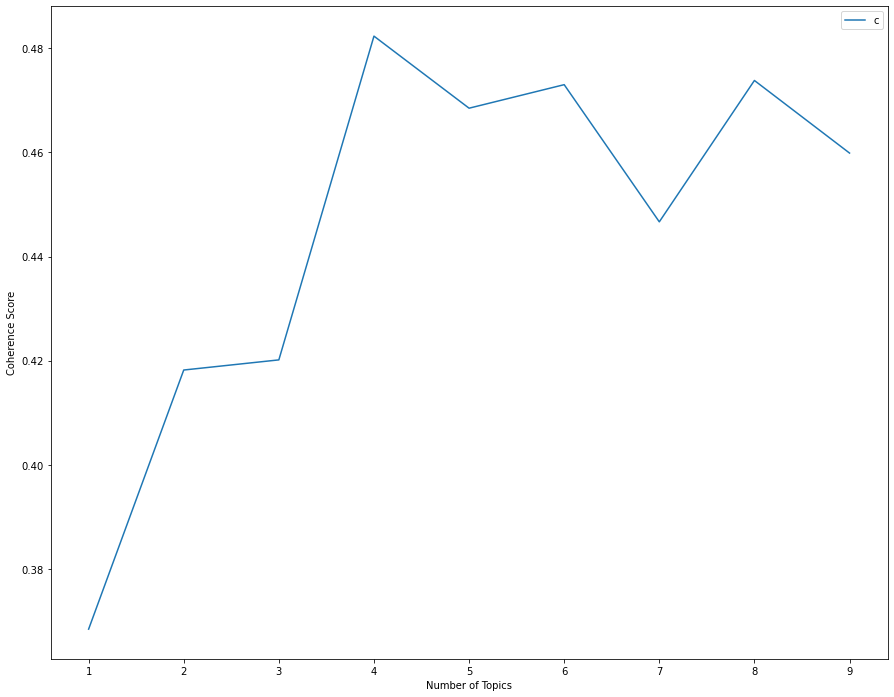

In [48]:
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Here we will do the actual LDA topic modeling with the best fitted number of topics (determined in from the graph). We make use of the gensim library for that. We save the model to the disk.

In [68]:
NUM_TOPICS = 4
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('./gensim/model.gensim')

We will now show a wordcloud per topic with the 20 most important words per topic.

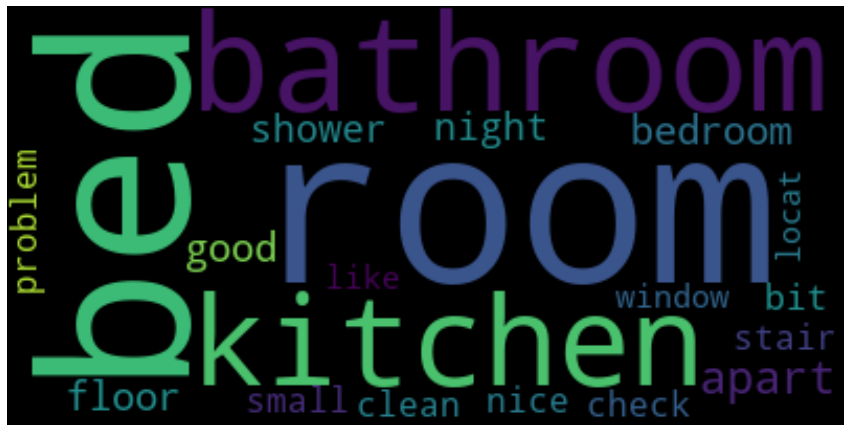

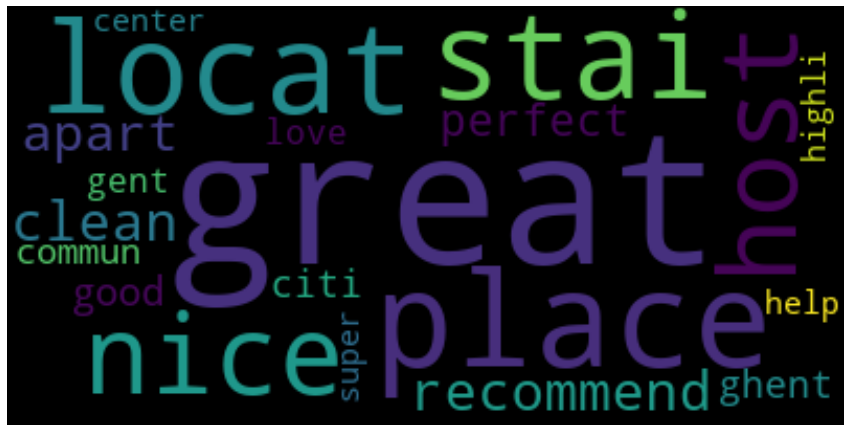

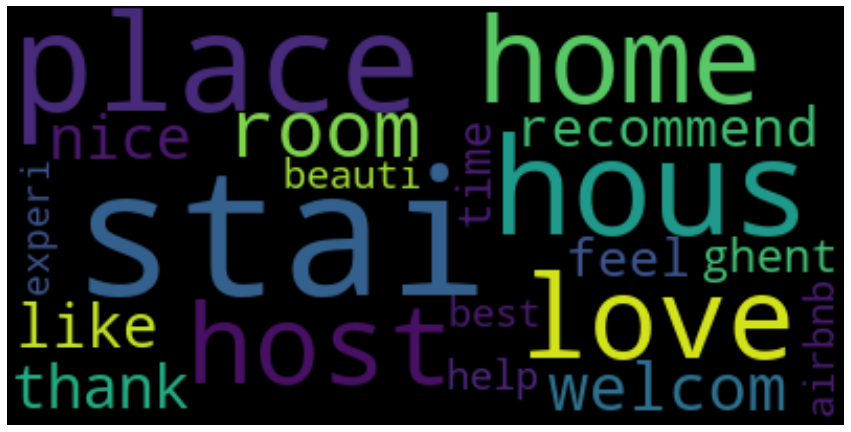

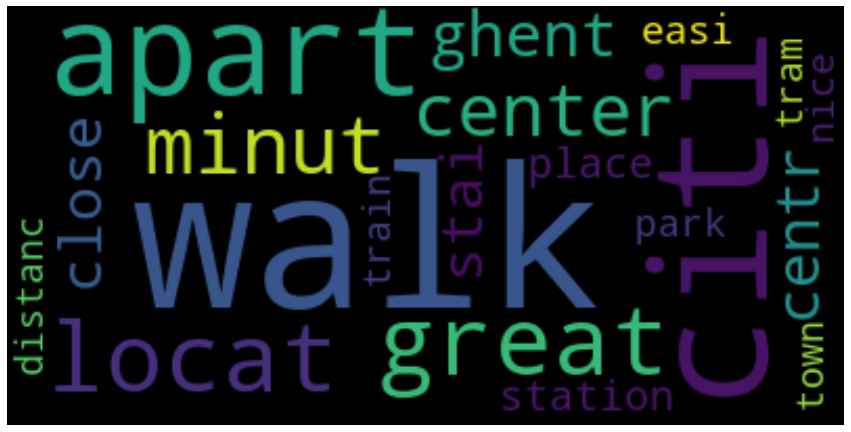

In [69]:
for t in range(ldamodel.num_topics):
    wordcloud = WordCloud().fit_words(dict(ldamodel.show_topic(t,20)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

We now visualize the LDA. Each circle corresponds to a topic. The distance between the topics shows how different they are. We can see which words are the most used ones in each topic. These can also be seen in the above wordclouds.

In [70]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamodel, corpus, dictionary)
vis

/home/lennertfranssens/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/lennertfranssens/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/lennertfranssens/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/lennertfranssens/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/lennertfranssens/anaconda3/lib/python3.8/site-

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.144632 -0.000939       1        1  27.955880
3     -0.083098  0.170178       2        1  27.187572
2     -0.036362 -0.195372       3        1  24.650238
0      0.264092  0.026133       4        1  20.206310, topic_info=      Term          Freq         Total Category  logprob  loglift
19    walk   6832.000000   6832.000000  Default  30.0000  30.0000
11   locat  11479.000000  11479.000000  Default  29.0000  29.0000
7    great  12955.000000  12955.000000  Default  28.0000  28.0000
104  minut   3041.000000   3041.000000  Default  27.0000  27.0000
64    home   2670.000000   2670.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
42    nice    817.596812   9705.821000   Topic4  -4.9878  -0.8749
11   locat    733.919009  11479.029423   Topic4  -5.0958  -1.1507
41    need    637.565922   3965.990332   Topic4  -5.2365  -0.2287
46    stai    691.969670  14642.868146   Topic4  -5.1546  -1.4530
44   place    596.109015  14791.068492   Topic4  -5.3037  -1.6122

[294 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
909        3  0.988199    ador
11285      1  0.978875   agnör
11285      3  0.015788   agnör
484        1  0.104998  airbnb
484        3  0.726423  airbnb
...      ...       ...     ...
150        1  0.102155    work
150        2  0.075000    work
150        3  0.089224    work
150        4  0.733191    work
932        3  0.994227   world

[441 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

We see that there are topics that are very different from other topics. These topics are isolated and lie far from other topics on the visualization. But there are also topcis that are almost the same as others, these have an overlap (partial) on the above LDA visualization.

# **6 - SENTIMENT ANALYSIS**

References:
* https://github.com/shahkshitij15/Unsupervised-Sentiment-Analysis/blob/main/Text_Analysis.ipynb

In this task we try to categorize reviews based on their sentiment. We will categorize reviews into positive and negative ones.

We make use of the TextBlob library to do the sentiment analysis and will make wordclouds of the most used words per category.

## Cleaning

We first clean the dataset. We make use of the earlier cleaned dataset with English-only reviews.

In [52]:
review_word_sentiments = english_reviews_copy.copy()

This basic clean is executed on an already cleaned dataset. It will clean earlier unseen or not needed anomalies in the sentences.

We use a dataset where there are no sentences anymore. Our library will see the review as one big sentence to evaluate the sentiment polarity of it.

In [53]:
def basic_clean(text):
  
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [54]:
words = basic_clean(''.join(str(review_word_sentiments['comments'].tolist())))

## Sentiment analysis

### Perform analysis

We will now make use of the TextBlob library to do the actual sentiment analysis. We apply this analysis on every cleaned review that is in the dataset. As we already know from section **4 - LISTING POSITIVE AND NEGATIVE POINTS FROM REVIEWS**, the returned object from TextBlob contains a sentiment attribute which stores a polarity value between [-1.0, 1.0].

In [55]:
def sentiment(text):
    senti = TextBlob(text)
    return senti.sentiment

review_word_sentiments['polarity'] = review_word_sentiments['comments'].apply(sentiment).apply(lambda x: x[0])

review_word_sentiments.head(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
0,187870,540088,2011-09-17,1003634,Dominick,this is very lovely room the room bathroom eve...,en,0.533810
1,187870,581572,2011-09-29,178012,Nancy,tamara place in ghent was really nice and clea...,en,0.301667
2,187870,715167,2011-11-13,1391583,Charlotte,we spend one night at tamara and it was perfec...,en,0.475000
4,187870,855004,2012-01-10,1503813,Max,my girlfriend and had the most wonderful time ...,en,0.455022
5,187870,897168,2012-02-01,581462,Eva,we had lovely stay with tamara and anna in ghe...,en,0.456636
6,187870,962644,2012-03-01,1749959,Angelina,the room and bathroom room are very big clean ...,en,0.155833
7,187870,990713,2012-03-12,589502,Kimberly,tamara was very helpful friendly and flexible ...,en,0.319167
9,187870,1117406,2012-04-12,1473093,Ingrid,tamara was very welcoming with us and she prov...,en,0.536000
10,187870,1152187,2012-04-19,1721286,Jacob,tamara was the ideal host good communication f...,en,0.379697
11,187870,1202724,2012-04-30,2093146,Corrine,wonderful setting with large area for me to wo...,en,0.343571


### Categorize sentiment

We now assigned a polarity value to each review. We will translate the clearest values to describe a review as positive or negative.

In [64]:
def categories(pol):
    if pol > 0.1:
        return 'positive'
    elif pol < 0.1:
        return 'negative'
    
review_word_sentiments['pd_sentiment'] = review_word_sentiments['polarity'].apply(categories)
review_word_sentiments.head(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity,pd_sentiment
0,187870,540088,2011-09-17,1003634,Dominick,this is very lovely room the room bathroom eve...,en,0.533810,positive
1,187870,581572,2011-09-29,178012,Nancy,tamara place in ghent was really nice and clea...,en,0.301667,positive
2,187870,715167,2011-11-13,1391583,Charlotte,we spend one night at tamara and it was perfec...,en,0.475000,positive
4,187870,855004,2012-01-10,1503813,Max,my girlfriend and had the most wonderful time ...,en,0.455022,positive
5,187870,897168,2012-02-01,581462,Eva,we had lovely stay with tamara and anna in ghe...,en,0.456636,positive
6,187870,962644,2012-03-01,1749959,Angelina,the room and bathroom room are very big clean ...,en,0.155833,positive
7,187870,990713,2012-03-12,589502,Kimberly,tamara was very helpful friendly and flexible ...,en,0.319167,positive
9,187870,1117406,2012-04-12,1473093,Ingrid,tamara was very welcoming with us and she prov...,en,0.536000,positive
10,187870,1152187,2012-04-19,1721286,Jacob,tamara was the ideal host good communication f...,en,0.379697,positive
11,187870,1202724,2012-04-30,2093146,Corrine,wonderful setting with large area for me to wo...,en,0.343571,positive


We make two new datasets where we store positive or negative reviews only.

In [65]:
pos_riv = review_word_sentiments[review_word_sentiments['pd_sentiment']=='positive']
pos_riv.drop('pd_sentiment', axis=1)

neg_riv = review_word_sentiments[review_word_sentiments['pd_sentiment']=='negative']
neg_riv.drop('pd_sentiment', axis=1)

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
45,187870,3523321,2013-02-11,2536154,Bea And Frans,a good room with everything you need there is ...,en,0.025000
59,187870,4552966,2013-05-12,297725,Jessica,i usually get bit nervous about the words sofa...,en,0.070833
99,187870,13553708,2014-05-30,16039754,Roger,the reservation was canceled 5 days before arr...,en,0.000000
104,187870,15439070,2014-07-08,17830596,Rick,the reservation was canceled 3 days before arr...,en,0.000000
234,187870,202862359,2017-10-13,125751141,Gene Paulo,place is clean cozy neighborhood is quiet fast...,en,0.091667
...,...,...,...,...,...,...,...,...
50451,46049306,752588593,2021-04-27,393571924,Felix,every thing os allright,en,0.000000
50455,46119402,712182708,2020-11-29,375507976,Juiller,the place 2be,en,0.000000
50521,46154732,388092781458312220,2021-06-19,29424458,Nikolina,i keep coming back to this airbnb for reason n...,en,0.000000
50566,46467298,726360122,2021-01-24,350484229,Maxence,incroyable,en,0.000000


Each of the two datasets contains now the most positive or negative reviews. We will make a wordcloud of each of these datasets with their most prominent used words in. By doing that, we can see which words are used the most in positive or negative reviews.

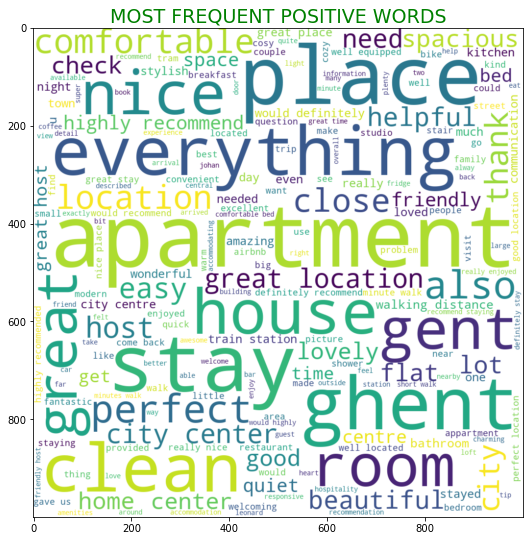

In [66]:
all_positive = " ".join(pos_riv['comments'])

st_words = set(stopwords.words('english'))

po_wcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = st_words, 
                min_font_size = 10).generate(all_positive)

plt.figure(figsize=(12,9))
plt.title("MOST FREQUENT POSITIVE WORDS",fontdict={'color':"green",'fontsize':19})
plt.imshow(po_wcloud,interpolation='bilinear')
plt.show()

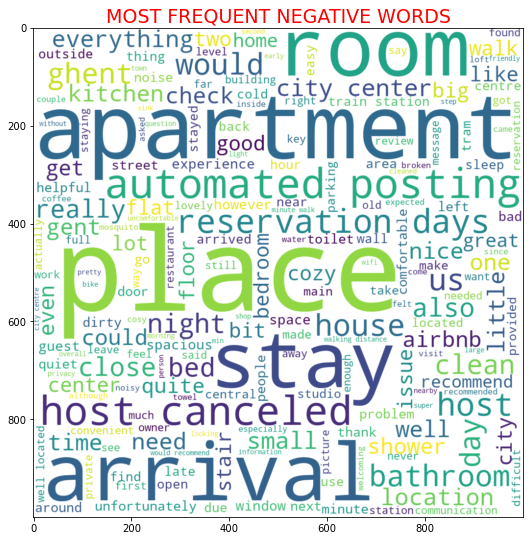

In [67]:
all_negative = " ".join(neg_riv['comments'])

neg_wcloud=WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = st_words, 
                min_font_size = 10).generate(all_negative)

plt.figure(figsize=(12,9))
plt.title("MOST FREQUENT NEGATIVE WORDS",fontdict={'color':'red','fontsize':19})
plt.imshow(neg_wcloud,interpolation='bilinear')
plt.show()

We see that this method works very well on the most frequent positive words. On the most frequent negative words it sometimes works. There are words like good, quiet, friendly, well located... that are not on their place on the last wordcloud. But there is also a prove that it still contains enough 'negative' words like: canceled, difficult, never, unfortunately, broken, far, noise, noisy, issue, problem...

# **7 - SIMILAR REVIEWS**

References:
* https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

We search for similar reviews in this task. We will make use of the universal sentence encoder (USE) model, made by Google. This model encodes text into high dimensional vectors. These vectors can be used for:
* Text classification
* Semantic similarity
* Clustering
* Many other NLP tasks

Because there is an optimization for greater-than-word length text, such as sentences, phrases or short paragraphs, it should be a perfect fit for similarity analysis on our reviews.

The model outputs a 512 dimensional vector, to which we can apply mathematical operations.

We will make use of the **semantic similarity** feature to perform our similarity analysis.

## Download and load USE model

First, we download and load the universal sentence encoder (USE) tensorflow model.

In [60]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

2021-11-21 15:44:43.079468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-21 15:44:43.079487: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-21 15:44:43.079499: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (berlin): /proc/driver/nvidia/version does not exist
2021-11-21 15:44:43.079628: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Processing and calculating similar reviews

As said in the previous section, we will make use of the semantic similarity feature to perform our analysis. That feature is a measure of the degree to which two texts carry the same meaning. This means that this feature can detect similar meanings even though they are expressed in another linguistic way.

A visual example to what this feature will do is given in the image below:

![](./images/similarity.png)

We make a function to embed all reviews with the downloaded model.

In [61]:
def embed(input):
  return model(input)

reviews_similar_embeddings = embed(reviews_similar['comments'])

2021-11-21 15:45:02.363766: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3205045760 exceeds 10% of free system memory.


We take the inner product of the encodings to compute the mutual semantic similarity of sentences. This creates a big matrix with the similarity per review with other reviews.

In [62]:
corr = np.inner(reviews_similar_embeddings, reviews_similar_embeddings)

## Writing out similar reviews

In the last step of this task, we write out all similar reviews per review. We provide an overview to which listings these reviews correspond. We also provide the *base review* on which the similarity is calculated.

We print out this analysis on the first 50 reviews with similar ones to keep this notebook compact. But this analysis can be done on the whole dataset.

In [63]:
counter = 0
break_counter = 0

for i in range(len(corr)):
    counter = 0
    for j in range(len(corr[i])):
        if corr[i][j] > 0.88 and i != j:
            print('Similar review (is for listing with id {}): {}'.format(reviews_similar['listing_id'].iloc[j], reviews_similar['comments'].iloc[j]))
            counter += 1
    if counter > 0:
        print('\nBase review (review id {} for listing with id {}):'.format(reviews_similar['id'].iloc[i], reviews_similar['listing_id'].iloc[i]))
        print(reviews_similar['comments'].iloc[i])
        print("\n--------------------------------\n")
        break_counter += 1
    if break_counter > 50:
        break

Similar review (is for listing with id 187870): the reservation was canceled 3 days before arrival. this is an automated posting.
Similar review (is for listing with id 216715): the reservation was canceled 71 days before arrival. this is an automated posting.
Similar review (is for listing with id 476371): the reservation was canceled 5 days before arrival. this is an automated posting.
Similar review (is for listing with id 599325): the reservation was canceled the day before arrival. this is an automated posting.
Similar review (is for listing with id 1121033): the reservation was canceled the day before arrival. this is an automated posting.
Similar review (is for listing with id 1378568): the reservation was canceled 3 days before arrival. this is an automated posting.
Similar review (is for listing with id 1723685): the reservation was canceled 18 days before arrival. this is an automated posting.
Similar review (is for listing with id 2138676): the reservation was canceled 54 da

If we take a look at the result, we see that all provided similar reviews are similar. This can mean that they are (almost) exactly the same, or have the same meaning.